# Spatial Extreme Process
## Author: Cheolhei Lee
## Date: Oct 26, 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from doe import lhd
from models import LatentExtreme, StochasticKriging
from preprocess import BlockMaxima
import warnings
warnings.filterwarnings("ignore")

This short note demonstrates how a simple spatial extreme process ([SEP](https://doi.org/10.1214/11-STS376)) works in nonGaussian stochastic process. That is, `f` define below is a stochastic function, which, over the unit interval, has nonstationary noise. Many applications assume (or equivocate) that the underlying function is Gaussian. Definitely, it may underestimate extreme risks, while SEPs can provide a good solution. We compare the SEP with latent variables to Stochastic Kriging (SK; [Ankenman et al., 2008](https://doi.org/10.1109/WSC.2008.4736089)), which addresses heteroscedasticity.

In [2]:
# define a nontrivial function
def noise_fun(x):
    return stats.skewnorm(1, scale=np.exp(np.sin(np.pi * 2 * x)) * 0.05)

def f(x, noise=True):
    if noise:
        return np.exp(np.sin(np.pi * 2 * x)) * x + noise_fun(x).rvs(size=x.shape)
    else:
        return np.exp(np.sin(np.pi * 2 * x)) * x

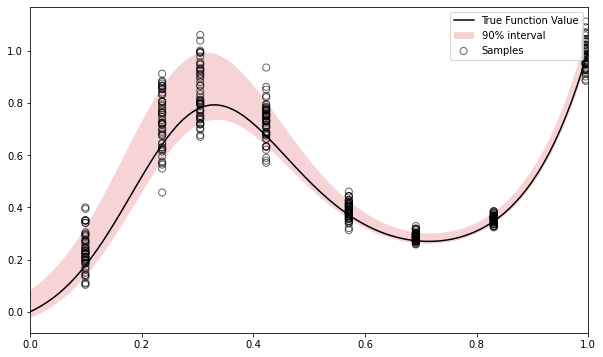

In [3]:
# replicate experiments at LatinHypercube-Maximin design points
reps = 50
q = 0.9
XX = np.linspace(0, 1, 100).reshape(-1, 1)
yy = f(XX, noise=False)
yy_ub = f(XX, noise=False) + noise_fun(XX).ppf(q)
yy_lb = f(XX, noise=False) + noise_fun(XX).ppf(1-q)
X = np.sort(lhd(8, 1, criterion='maximin', seed=0), 0)
X_reps = np.tile(X, reps)
y = f(X_reps)

plt.figure(figsize=(10, 6))
plt.plot(XX, yy, 'k', label='True Function Value')
plt.fill_between(XX.ravel(), yy_lb.ravel(), yy_ub.ravel(), alpha=0.2, color='tab:red', edgecolors='None', label=f'{q:.0%} interval')
plt.scatter(X_reps, y, edgecolors='k', facecolor='None', alpha=0.6, s=50, label='Samples'); plt.margins(x=0); plt.legend(); plt.show()

In [4]:
bm = BlockMaxima(20)
y_maxima = bm.get_maxima(y)

In [5]:
# fit SEP and SK
kwargs = {'alpha': 1e-8, 'n_restarts_optimizer': 5}
sep = LatentExtreme(input_dim=1, **kwargs)
sep.fit(X, y_maxima)
sk = StochasticKriging()
sk.fit(X, y_maxima)
# yy_ext_samples = sep.predict(XX)
yy_ext_median = sep.predict_ppf(XX, q=q)
yy_sk, std_sk = sk.predict(XX, return_std=True)

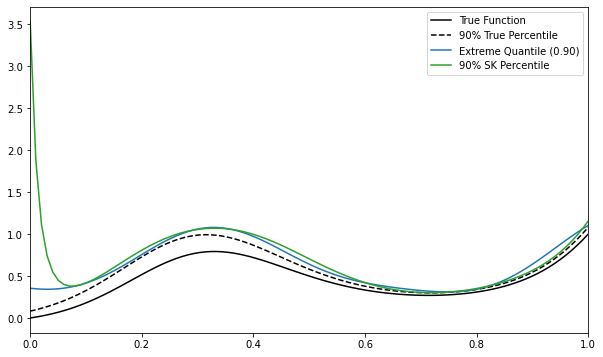

In [6]:
# visualize the result
q = 0.9  # quantile level
plt.figure(figsize=(10, 6))
plt.plot(XX, yy, 'k', label='True Function')
plt.plot(XX, yy_ub, 'k--', label=f'{q:.0%} True Percentile')
# plt.scatter(XX, yy_ext_samples, c='r', edgecolors='k', alpha=0.5, clip_on=False, label='Extreme Samples')
# plt.scatter(np.tile(X, 5), sep.predict(np.tile(X, 5), 5), c='r', s=50, edgecolors='k', alpha=0.5, clip_on=False, label='Extreme Samples')
plt.plot(XX, yy_ext_median, 'tab:blue', label='Extreme Quantile (%.2f)'%q)
plt.plot(XX, yy_sk + stats.norm.ppf(q) * std_sk, 'tab:green', label=f'{q:.0%} SK Percentile')
plt.margins(x=0); plt.legend(); plt.show()

As we can see, the SEP models extreme values of the function than the SK, whch underestimates the extreme values even with a high percentile (99%).

## Application of non-extreme data intervention

In [7]:
W = np.zeros((8, 8))
for i in range(8):
    for j in range(i+1, 8):
        W[i, j] = stats.wasserstein_distance(y[i], y[j])
        W[j, i] = W[i, j]

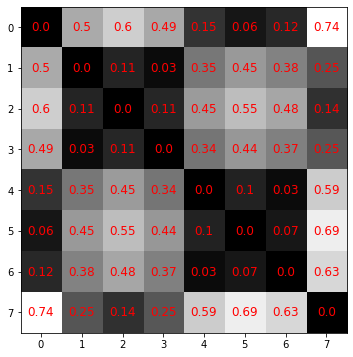

In [8]:
plt.figure(figsize=(6, 6))
plt.imshow(W, cmap='gray')
for i in range(8):
    for j in range(8):
        text = plt.text(j, i, np.round(W[i, j], 2), ha='center', va='center', color='r', size=12)

In [9]:
mu, sigma, xi = sep.get_params(X)

In [10]:
from scipy.spatial.distance import cdist

In [11]:
D_mu = cdist(mu[:, None], mu[:, None])
D_sigma = cdist(sigma[:, None], sigma[:, None])
D_xi = cdist(xi[:, None], xi[:, None])

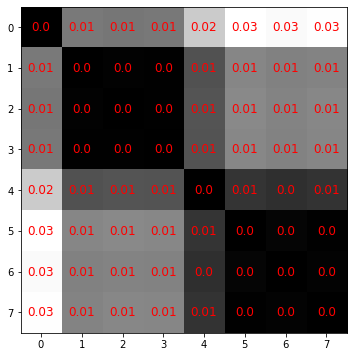

In [12]:
plt.figure(figsize=(6, 6))
plt.imshow(D_xi, cmap='gray')
for i in range(8):
    for j in range(8):
        text = plt.text(j, i, np.round(D_xi[i, j], 2), ha='center', va='center', color='r', size=12)

In [13]:
W_vec = W[np.tril_indices(W.shape[0], 1)]
D_mu_vec = D_mu[np.tril_indices(W.shape[0], 1)]
D_sigma_vec = D_sigma[np.tril_indices(W.shape[0], 1)]
D_xi_vec = D_xi[np.tril_indices(W.shape[0], 1)]

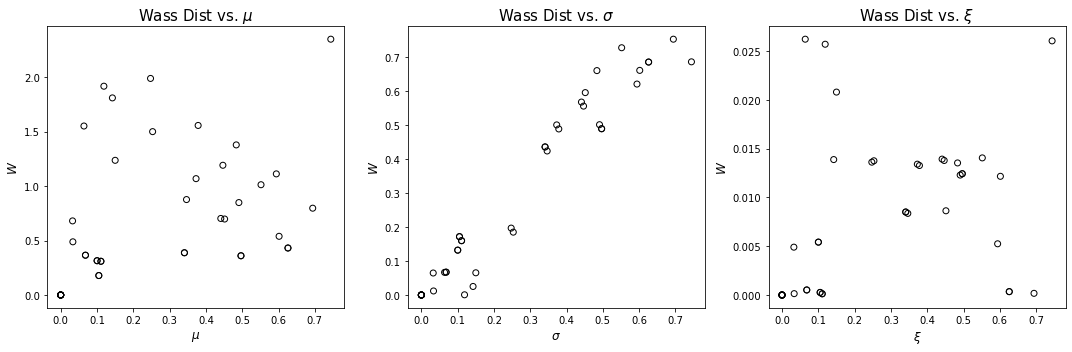

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].set_title(r'Wass Dist vs. $\mu$', fontsize=15)
ax[0].scatter(W_vec, D_mu_vec, facecolor='None', edgecolor='k')
ax[0].set_xlabel(r'$\mu$', fontsize=12)
ax[0].set_ylabel(r'$W$', fontsize=12)
ax[1].set_title(r'Wass Dist vs. $\sigma$', fontsize=15)
ax[1].scatter(W_vec, D_sigma_vec, facecolor='None', edgecolor='k')
ax[1].set_xlabel(r'$\sigma$', fontsize=12)
ax[1].set_ylabel(r'$W$', fontsize=12)
ax[2].set_title(r'Wass Dist vs. $\xi$', fontsize=15)
ax[2].scatter(W_vec, D_xi_vec, facecolor='None', edgecolor='k')
ax[2].set_xlabel(r'$\xi$', fontsize=12)
ax[2].set_ylabel(r'$W$', fontsize=12)
plt.tight_layout();plt.show()

In [16]:
d_max = np.zeros(len(XX))
for i, x in enumerate(XX):
    y = stats.genextreme(*sep.get_params(x.reshape(-1, 1))).rvs(50)
    y_max = np.zeros(8)
    for j, ym in enumerate(y_maxima):
        y_max[j] = stats.wasserstein_distance(y, ym)
    d_max[i] = y_max.max()

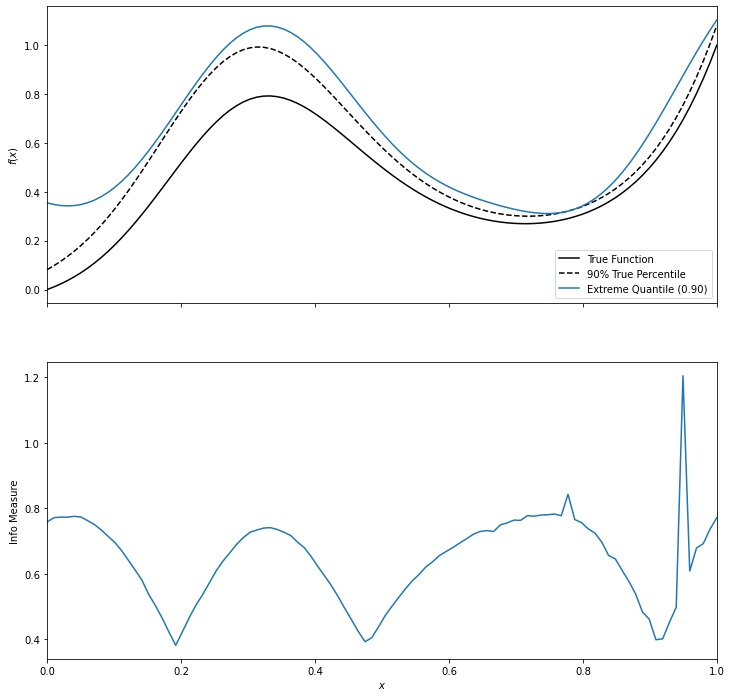

In [17]:
# visualize the result
q = 0.9  # quantile level
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
axes[0].plot(XX, yy, 'k', label='True Function')
axes[0].plot(XX, yy_ub, 'k--', label=f'{q:.0%} True Percentile')
# plt.scatter(XX, yy_ext_samples, c='r', edgecolors='k', alpha=0.5, clip_on=False, label='Extreme Samples')
# axes[0].scatter(np.tile(X, 5), sep.y_maxima, c='r', s=50, edgecolors='k', alpha=0.5, clip_on=False, label='Extreme Samples')
axes[0].plot(XX, yy_ext_median, 'tab:blue', label='Extreme Quantile (%.2f)'%q)
# axes[0].plot(XX, yy_sk + stats.norm.ppf(q) * std_sk, 'tab:green', label=f'{q:.0%} SK Percentile')
axes[0].legend(loc=4)
axes[1].plot(XX, d_max); axes[1].set_xlabel(r'$x$'); axes[1].set_ylabel('Info Measure'); axes[0].set_ylabel(r'$f(x)$')
axes[0].margins(x=0); axes[1].margins(x=0); plt.show()

In [18]:
a = np.random.rand(20)
b = np.random.randn(50)

In [118]:
from scipy.optimize import minimize

In [152]:
# scipy default estimation machine
# 1. MLE
a = np.random.normal(1.2, 2.5, 50)

theta_mle = stats.norm.fit(a, method='MLE')
print('theta_mle:', theta_mle)
theta_mm = stats.norm.fit(a, method='MM')
print('theta_mm:', theta_mm)

theta_mle: (1.351273636778155, 2.4130403327630545)
theta_mm: (1.351273636778155, 2.4130403327630545)


In [164]:
def mde(theta, a, m=1000):
    d = []
    for i in range(50):
        b = stats.norm.rvs(*theta, m)
        d.append(stats.wasserstein_distance(a, b))
    return np.array(d).mean()

def callback(theta):
    global a
    print(theta, mde(theta, a))

In [170]:
x0 = np.random.rand(2)
print(x0)
res = minimize(mde, x0, args=(a, 300), method='Nelder-Mead', callback=callback)
res.x

[0.49441241 0.35937731]
[0.53149334 0.38633061] 1.6599821940580934
[0.50059257 0.42676055] 1.6349134006044235
[0.55930404 0.46494439] 1.5918076360967996
[0.52685823 0.56489621] 1.5285095132289945
[0.62805827 0.69123979] 1.4051572352817359
[0.61376666 0.95431521] 1.2270846160155156
[0.80902093 1.33854009] 0.8907666981177711
[0.87806486 2.05680337] 0.5316090466745285
[1.07331913 2.44102825] 0.3495388719931703
[1.07331913 2.44102825] 0.3545612121924185
[1.07331913 2.44102825] 0.35292971437500303
[1.07331913 2.44102825] 0.3658723169995406
[1.07331913 2.44102825] 0.36277267271372504
[1.17760925 2.4483281 ] 0.3205080134247812
[1.17760925 2.4483281 ] 0.3212419792477344
[1.25563371 2.3174923 ] 0.30621748456046505
[1.28189937 2.45562796] 0.31112954765403994
[1.26876654 2.38656013] 0.30033434281505234
[1.36649024 2.35932607] 0.31461578081362673
[1.36649024 2.35932607] 0.3114511387000247
[1.36649024 2.35932607] 0.3099167424145446
[1.36649024 2.35932607] 0.30744809029892134
[1.36649024 2.35932607]

array([1.36655979, 2.35905359])